In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from matplotlib.ticker import FuncFormatter, NullFormatter

In [4]:
# Load the .txt file
file_name = r'\\server\groups\ding\PROJECTS\QKD_Perovskites\TimeTagger\20251215\Bidirectional_histogram_10ps_2025-12-15_174023.txt' 
data = pd.read_csv(file_name, sep="\t")  # Read the file with tab as the delimiter

# Extract the columns
x = data["Time differences (ps)"]
y = data["Counts per bin"]

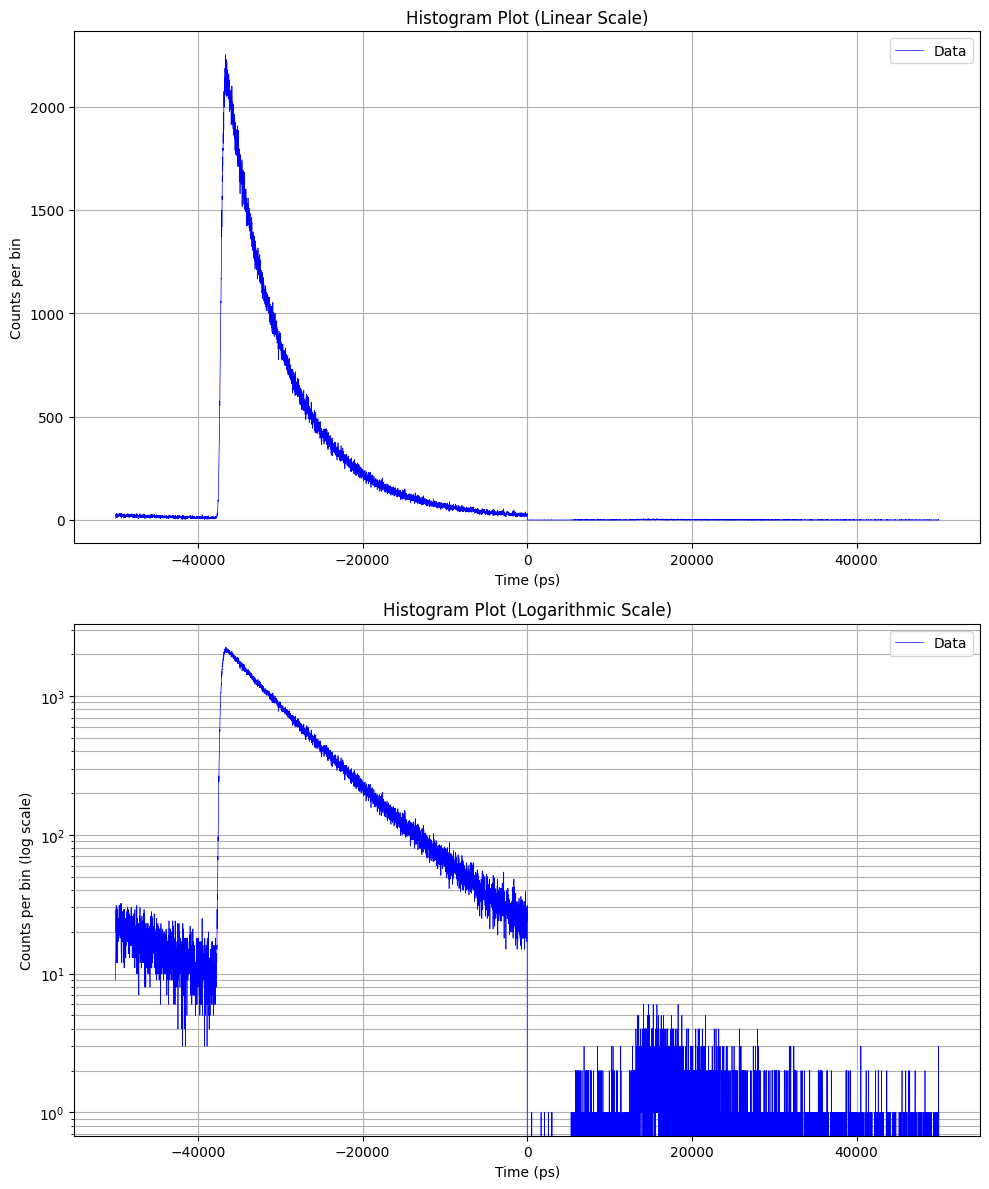

In [6]:
# Customize figure size and point size
fig_size = (10, 12)  # Total figure size (width, height in inches)
point_size = 10  # Size of the points

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=fig_size)  # 2 rows, 1 column

# First plot: Linear scale
axs[0].plot(x, y, marker='o', color='blue', markersize=0, linestyle='-', linewidth=0.5, label='Data')
axs[0].set_title('Histogram Plot (Linear Scale)')
axs[0].set_xlabel('Time (ps)')
axs[0].set_ylabel('Counts per bin')
axs[0].grid(True)
axs[0].legend()

# Second plot: Logarithmic scale on Y-axis
axs[1].plot(x, y, marker='o', color='blue', markersize=0, linestyle='-', linewidth=0.5, label='Data')
axs[1].set_title('Histogram Plot (Logarithmic Scale)')
axs[1].set_xlabel('Time (ps)')
axs[1].set_ylabel('Counts per bin (log scale)')
axs[1].set_yscale('log')  # Set Y-axis to logarithmic scale
axs[1].grid(True, which="both")  # Enable grid for both major and minor ticks
axs[1].legend()

# Adjust layout
plt.tight_layout()
# Display the plots
plt.show()

In [71]:
# ----- Model: double exponential -----
def double_exp(x, A, tau1, B, tau2):
    return A * np.exp(-x / tau1) + B * np.exp(-x / tau2)

# ----- Fitting and plotting function -----
def fit_double_exponential(
    x, y, x_start, x_end,
    y_scale="linear",
    x_plot_min=None, x_plot_max=None,
    font_size=12,
    fig_width=8, fig_height=5
):
    """
    Fit a double exponential to data in a given range and plot results.

    Parameters:
    - x, y: experimental data arrays
    - x_start, x_end: fit range
    - y_scale: "linear" or "log"
    - x_plot_min, x_plot_max: visible x-axis range
    - font_size: size of numbers, labels, legend
    - fig_width, fig_height: size of figure in inches
    """

    # ----- Select fitting range -----
    mask = (x >= x_start) & (x <= x_end)
    x_fit = x[mask]
    y_fit = y[mask]

    # ----- Initial guesses -----
    A0 = y_fit.max()
    B0 = y_fit.max() / 2
    tau10 = (x_end - x_start) / 5
    tau20 = (x_end - x_start)
    p0 = [A0, tau10, B0, tau20]

    # ----- Fit with bounds (all positive) -----
    lower_bounds = [0, 0, 0, 0]        # A, tau1, B, tau2 > 0
    upper_bounds = [np.inf, np.inf, np.inf, np.inf]

    popt, pcov = curve_fit(
        double_exp,
        x_fit,
        y_fit,
        p0=p0,
        bounds=(lower_bounds, upper_bounds),
        maxfev=10000
    )

    # ----- Plotting range -----
    if x_plot_min is None:
        x_plot_min = x.min()
    if x_plot_max is None:
        x_plot_max = x.max()

    # Curve only inside fit range
    x_fit_plot = np.linspace(x_start, x_end, 500)
    y_fit_plot = double_exp(x_fit_plot, *popt)

    # ----- Plot -----
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    # Scatter experimental data
    ax.scatter(x, y, s=20, color="black", label="Experimental data")
    # Fit curve only in fit range, label showing average tau
    ax.plot(
        x_fit_plot, y_fit_plot, "r", linewidth=2,
        label=f"$\\tau_{{avg}}$ = {np.mean([popt[1], popt[3]])/1000:.4g} ns"
    )
    # Highlight fit range
    ax.axvspan(x_start, x_end, color="gray", alpha=0.2, label="Fit range")

    # Labels and scale
    ax.set_xlabel("Time (ns)", fontsize=font_size)
    ax.set_ylabel("Counts (a.u.)", fontsize=font_size)
    ax.set_yscale(y_scale)
    ax.set_xlim(x_plot_min, x_plot_max)

    # ----- Y-axis: hide numbers -----
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_minor_formatter(NullFormatter())

    # ----- X-axis: force tick at x_start and shift by x_start -----
    ticks = list(ax.get_xticks())
    if x_start not in ticks:
        ticks.append(x_start)
    ticks = np.array(sorted(ticks))
    ax.set_xticks(ticks)

    # Formatter: shift all ticks by x_start and multiply by 1000
    ax.xaxis.set_major_formatter(
        FuncFormatter(lambda val, pos: f"{(val - x_start)/1000:.0f}")
    )
    # Increase tick label size
    ax.tick_params(axis='x', labelsize=font_size)
    ax.tick_params(axis='y', labelsize=font_size)

    # Legend font size
    ax.legend(fontsize=font_size)

    ax.grid(True, which="both")
    plt.tight_layout()
    plt.show()

    # ----- Print fitted parameters -----
    A, tau1, B, tau2 = popt
    print("Fitted parameters:")
    print(f"A     = {A:.4g}")
    print(f"tau1  = {tau1:.4g}")
    print(f"B     = {B:.4g}")
    print(f"tau2  = {tau2:.4g}")

    return popt, pcov

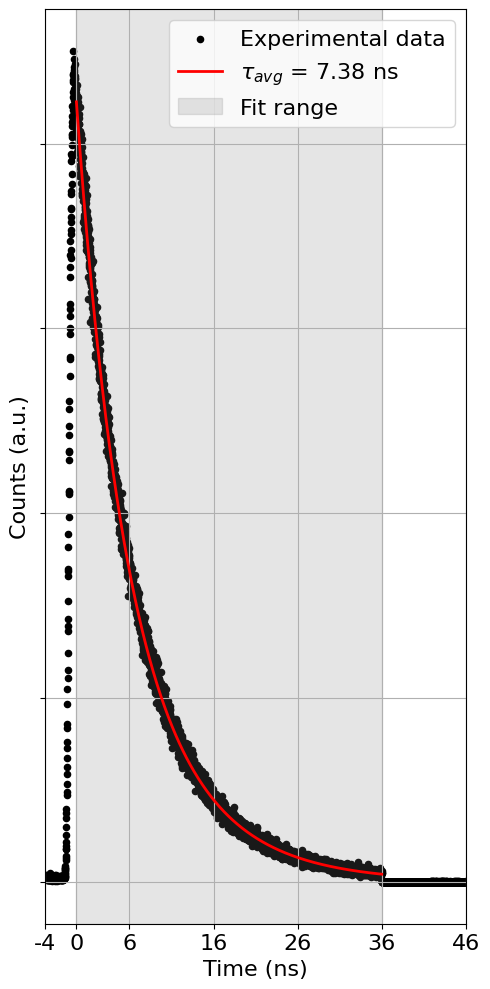

Fitted parameters:
A     = 1.276
tau1  = 5326
B     = 20.25
tau2  = 9435


In [73]:
# Control the sacle in the y axis wit "log" or "linear".

popt, pcov = fit_double_exponential(
    x, y,
    x_start=-36300, x_end=-10,
    y_scale="linear",
    x_plot_min=-40000,
    x_plot_max=10000,
    font_size=16,
    fig_width=5, fig_height=10
)

In [74]:
# ----- Model: single exponential -----
def single_exp(x, A, tau):
    return A * np.exp(-x / tau)

# ----- Fitting and plotting function -----
def fit_single_exponential(
    x, y, x_start, x_end,
    y_scale="linear",
    x_plot_min=None, x_plot_max=None,
    font_size=12,
    fig_width=8, fig_height=5
):
    """
    Fit a single exponential to data in a given range and plot results.

    Parameters:
    - x, y: experimental data arrays
    - x_start, x_end: fit range
    - y_scale: "linear" or "log"
    - x_plot_min, x_plot_max: visible x-axis range
    - font_size: size of numbers, labels, legend
    - fig_width, fig_height: size of figure in inches
    """

    # ----- Select fitting range -----
    mask = (x >= x_start) & (x <= x_end)
    x_fit = x[mask]
    y_fit = y[mask]

    # ----- Initial guesses -----
    A0 = y_fit.max()
    tau0 = (x_end - x_start) / 3
    p0 = [A0, tau0]

    # ----- Fit -----
    popt, pcov = curve_fit(single_exp, x_fit, y_fit, p0=p0, maxfev=10000)
    A, tau = popt

    # ----- Plotting range -----
    if x_plot_min is None:
        x_plot_min = x.min()
    if x_plot_max is None:
        x_plot_max = x.max()

    # Curve only inside fit range
    x_fit_plot = np.linspace(x_start, x_end, 500)
    y_fit_plot = single_exp(x_fit_plot, *popt)

    # ----- Plot -----
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    # Scatter experimental data
    ax.scatter(x, y, s=20, color="black", label="Experimental data")
    # Fit curve only in fit range, label showing tau
    ax.plot(
        x_fit_plot, y_fit_plot, "r", linewidth=2,
        label=f"$\\tau$ = {tau/1000:.4g}"
    )
    # Highlight fit range
    ax.axvspan(x_start, x_end, color="gray", alpha=0.2, label="Fit range")

    # Labels and scale
    ax.set_xlabel("Time (ns)", fontsize=font_size)
    ax.set_ylabel("Counts (a.u.)", fontsize=font_size)
    ax.set_yscale(y_scale)
    ax.set_xlim(x_plot_min, x_plot_max)

    # ----- Y-axis: hide numbers -----
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_minor_formatter(NullFormatter())

    # ----- X-axis: force tick at x_start and shift by x_start -----
    ticks = list(ax.get_xticks())
    if x_start not in ticks:
        ticks.append(x_start)
    ticks = np.array(sorted(ticks))
    ax.set_xticks(ticks)

    # Formatter: shift all ticks by x_start and multiply by 1000
    ax.xaxis.set_major_formatter(
        FuncFormatter(lambda val, pos: f"{(val - x_start)/1000:.0f}")
    )
    # Increase tick label size
    ax.tick_params(axis='x', labelsize=font_size)
    ax.tick_params(axis='y', labelsize=font_size)

    # Legend font size
    ax.legend(fontsize=font_size)

    ax.grid(True, which="both")
    plt.tight_layout()
    plt.show()

    # ----- Print fitted parameters -----
    print("Fitted parameters:")
    print(f"A   = {A:.4g}")
    print(f"tau = {tau:.4g}")

    return popt, pcov

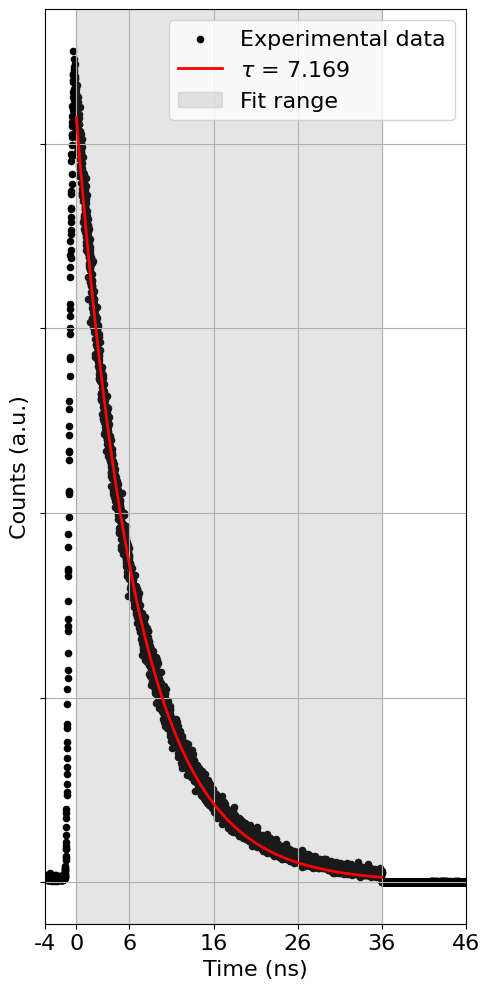

Fitted parameters:
A   = 13.1
tau = 7169


In [76]:
# Control the sacle in the y axis wit "log" or "linear".

popt, pcov = fit_single_exponential(
    x, y,
    x_start=-36300, x_end=-10,
    y_scale="linear",
    x_plot_min=-40000,
    x_plot_max=10000,
    font_size=16,
    fig_width=5, fig_height=10
)